# Sommaire

### Segmentation RFM ; approche analytique
- Traitement des outliers 
- Data prepration : rencentrage des données 
- Stratégie de la segmentation 
- Création d'un score RFM pour chaque clients
- Visualisation des segmentation RFM



### Segementation RFM ; approche automatique avec algorithme de clustering 
- Clustering avec KMEANS 
- Data prepration 
- Trouver le nombre optimal de K avec Elbow Methode et distortion score
- Evaluer l'algorithme Kmeans
    - Coefficient de silhouette 
    - Forme des clusters 
    - Stabilité des clusteres 
- Identifier les composantes métier de chaque cluster
- Visualisation des clusters 

### Clustering sur l'ensemble des varaibles ; algorithme Kmeans 
- Trouver le nombre optimal de K avec Elbow Methode et distortion score
- Evaluer l'algorithme Kmeans
    - Coefficient de silhouette 
    - Forme des clusters 
    - Stabilité des clusteres 
- Identifier les composantes métier de chaque cluster
- Visualisation des clusters
### Conclusion


In [1]:
#Importer les librairies

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import glob
import warnings
from time import time

import datetime
from datetime import datetime as dt
from scipy import stats

warnings.filterwarnings('ignore')

import squarify

from sklearn.preprocessing import MinMaxScaler, StandardScaler
 

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score, davies_bouldin_score

from scipy.spatial.distance import cdist  

import plotly.graph_objects as go
from sklearn.manifold import TSNE

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance


## Segmentation RFM ; approche analytique 

**Qu'est-ce que la ségmentation RFM?** 
- La RFM est une technique de segmentation des clients, basée sur 3 données :
        - La Récence : qui correspond à la date du dernier achat 
        - La Fréquence : qui correspond au nombre d’achats effectués sur une période précise. 
        - Le Montant : qui correspondant au total des achats sur la même période
- L'objectif de la segmentation RFM est de tirer profit des comportements passés de vos clients afin de prédire leurs réactions à vos campagnes futures.


In [2]:
# importer les données 
rfm_df= pd.read_csv(r"C:\Users\faeze\OneDrive\Documents\OC data science\PROJECT\Projet5\rfm_df.csv")

In [3]:
## Créer un dataframe avec les trois variables "Recence", "Frequence" , "Monetary"
rfm = rfm_df[['customer_unique_id','panier_moyen', 'recence', 'frequence']]

### Analyse descriptive de dataframe RFM 

In [4]:
rfm.describe()

panier_moyen       recence     frequence
count   92746.000000  92746.000000  92746.000000
mean      204.376237    237.798245      1.033177
std       603.916800    152.591525      0.208425
min         9.590000      1.000000      1.000000
25%        63.150000    114.000000      1.000000
50%       110.700000    219.000000      1.000000
75%       195.690000    346.000000      1.000000
max    109312.640000    695.000000     15.000000

Text(0.5, 1.0, 'La distribution de recence')

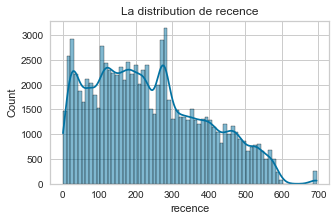

In [5]:
plt.figure(figsize = (5,3))
sns.histplot(x='recence', data=rfm, kde=True)
plt.title("La distribution de recence", )

<AxesSubplot:xlabel='panier_moyen', ylabel='Density'>

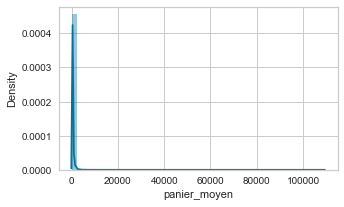

In [6]:
plt.figure(figsize = (5,3))
sns.distplot(rfm['panier_moyen'], kde= True)

<AxesSubplot:xlabel='frequence', ylabel='Count'>

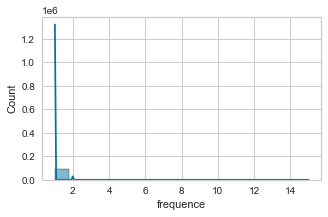

In [7]:
plt.figure(figsize = (5,3))
sns.histplot(data = rfm,x ='frequence', kde= True)

<AxesSubplot:>

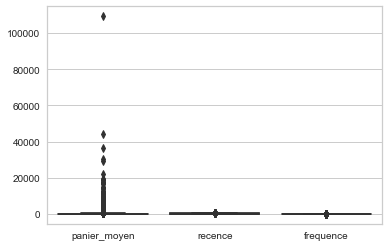

In [8]:
# Détecter les outliers 
sns.boxplot(data=rfm)

### Traimetments des outliesrs 

In [9]:
# Supprimers des outliesrs de panier_moyen avec Zcore
z=np.abs(stats.zscore(rfm.panier_moyen))

threshold=3
rfm_final = rfm[(z< 3)]

print("Nmbre de ligne supprimées après le traitment des outliers : ",rfm.shape[0] - rfm_final.shape[0] )

Nmbre de ligne supprimées après le traitment des outliers :  623


<AxesSubplot:>

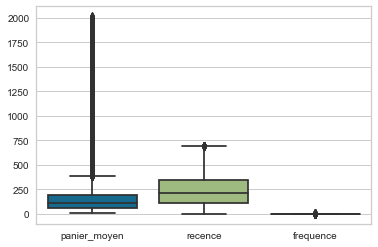

In [10]:
sns.boxplot(data=rfm_final)

### Data prepration

Text(0.5, 1.0, 'La distribution des donnée après le traitment \n des outliers et le recentrage')

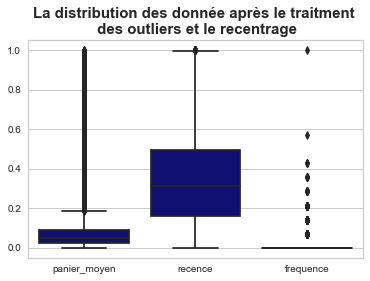

In [11]:
# recentrage des données avec MinMax 
minmax = MinMaxScaler()
rfm_to_scale = rfm_final.drop('customer_unique_id', axis= 1)
rfm_normalized = pd.DataFrame(minmax.fit_transform(rfm_to_scale), columns=['panier_moyen', 'recence', 'frequence'])


sns.boxplot(data=rfm_normalized, color= 'navy')
plt.title("La distribution des donnée après le traitment \n des outliers et le recentrage", fontsize = 15, weight = 'bold' )

<AxesSubplot:xlabel='frequence', ylabel='Density'>

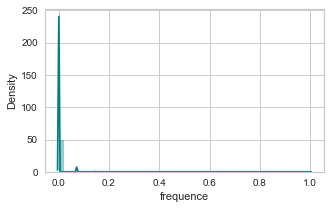

In [12]:
plt.figure(figsize = (5,3))
sns.distplot(rfm_normalized.frequence, kde=True, color = 'teal')

<AxesSubplot:xlabel='recence', ylabel='Density'>

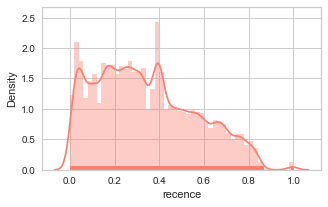

In [13]:
plt.figure(figsize = (5,3))
sns.distplot(rfm_normalized.recence,rug = True, color= 'salmon')

<AxesSubplot:xlabel='panier_moyen', ylabel='Density'>

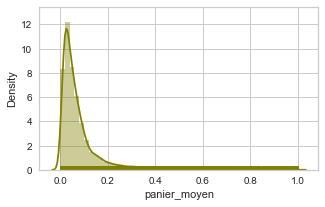

In [14]:
plt.figure(figsize = (5,3))
sns.distplot(rfm_normalized.panier_moyen, kde= True, rug = True, color = 'olive')

## Stratégie pour segmentation RFM des clients

- Selon les objectifs de l'entreprise, les clients peuvent être segmentés de plusieurs façons afin qu'il soit financièrement possible de faire des campagnes marketing. 
- Les clients idéaux pour les entreprises de e-commerce sont généralement les plus récents par rapport à la date d'étude (notre date de référence), qui sont très fréquents et qui dépensent suffisamment.

- Sur la base du tableau RFM, nous attribuerons trois score 'R', 'F', 'M' à chaque client 

- Le formule de calcule de RFM_score :

- Le moyenne de ces trois scores est le "RFM_score" pour chaque client

- Pour calculer trois score 'R', 'F', 'M', on divise le standanrd deviation de chaque variable par le somme des std de trois varibles

### Création de score RFM  

In [15]:
std_r = rfm_normalized['recence'].std()
std_f = rfm_normalized['frequence'].std()
std_m = rfm_normalized['panier_moyen'].std()

sum_var = std_r + std_f + std_m 

# Crée un poid pour R, F, M
w_r = std_r/ sum_var
w_f = std_f / sum_var
w_m = std_m /sum_var

#Créer un Score R, F et M basé sur le poid 
rfm_normalized['R_score'] = w_r * rfm_normalized['recence']
rfm_normalized['F_score'] = w_f * rfm_normalized['frequence']
rfm_normalized['M_score'] = w_m * rfm_normalized['panier_moyen']

# Créer un score final de RFM 
rfm_normalized['RFM_score'] =  ((rfm_normalized['R_score'] + rfm_normalized['F_score'] + rfm_normalized['M_score']))/3


Text(0.5, 1.0, 'Distribution de RFM_Score')

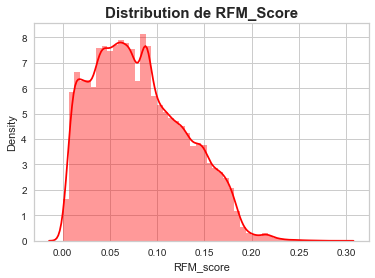

In [16]:
sns.distplot(rfm_normalized["RFM_score"], color = 'red')
plt.title("Distribution de RFM_Score", fontsize = 15, weight = 'bold')

### Déterminer les 4 types des clients 
- On va regrouoer le clients en 4 catégories selon leur Score RFM 
    - VIP customers (best client)
    - Prpmissing Customers
    - Potential Customers 
    - Lost Customers 

In [19]:
quantile_20 = round(rfm_normalized['RFM_score'].quantile(.20), 3)
quantile_50 = round(rfm_normalized['RFM_score'].quantile(.50), 3)
quantile_80 = round(rfm_normalized['RFM_score'].quantile(.80), 3)
def segmentaion_func(x):
    """Returns the a segment_label relative to quartile value"""
    if x <= quantile_20:
        return 'Lost_customer'
    elif  (x > quantile_20 and  x <=quantile_50):
        return 'Almost_Lost_Customer'
    elif (x > quantile_50 and x < quantile_80): 
        return 'Potential_customer'
    elif x > quantile_80 :
        return 'VIP_customers'

    
rfm_normalized['Segment_label'] = rfm_normalized['RFM_score'].apply(segmentaion_func)
rfm_normalized.head()

panier_moyen   recence  frequence   R_score  F_score   M_score  RFM_score  \
0      0.065977  0.159942        0.0  0.102190      0.0  0.020971   0.041054   
1      0.008776  0.164265        0.0  0.104952      0.0  0.002790   0.035914   
2      0.038212  0.772334        0.0  0.493458      0.0  0.012146   0.168535   
3      0.016969  0.461095        0.0  0.294602      0.0  0.005394   0.099998   
4      0.093398  0.413545        0.0  0.264221      0.0  0.029687   0.097969   

          Segment_label  
0  Almost_Lost_Customer  
1         Lost_customer  
2         VIP_customers  
3    Potential_customer  
4    Potential_customer

## Visualisation des segmentations RFM 

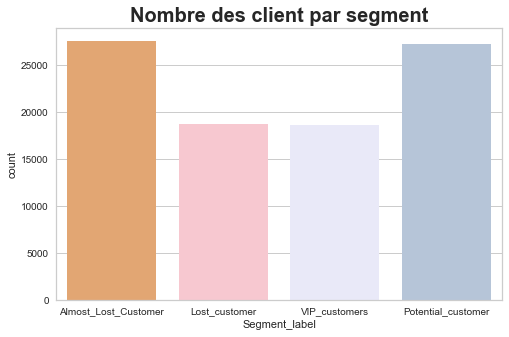

In [20]:
rfm_nbr_seg = pd.DataFrame(rfm_normalized['Segment_label'].value_counts()).reset_index()
rfm_nbr_seg.columns =  ["segment", "nmbr_seg"]
palette = ["#F4A460",  "#FFC0CB", "#E6E6FA", "#B0C4DE"]
plt.figure(figsize=(8,5))
sns.countplot(rfm_normalized['Segment_label'], palette= palette)
plt.title("Nombre des client par segment", fontsize= 20, weight = 'bold')
plt.show()

In [21]:
# Treemap de la segmentation  
df_rfm_agg = pd.DataFrame(rfm_normalized.groupby('Segment_label').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'panier_moyen': ['mean', 'count']
})).reset_index()
df_rfm_agg

Segment_label   recence frequence panier_moyen       
                             mean      mean         mean  count
0  Almost_Lost_Customer  0.228378  0.002570     0.073867  27566
1         Lost_customer  0.071222  0.002570     0.053944  18759
2    Potential_customer  0.417278  0.002297     0.090978  27207
3         VIP_customers  0.669636  0.001963     0.117784  18591

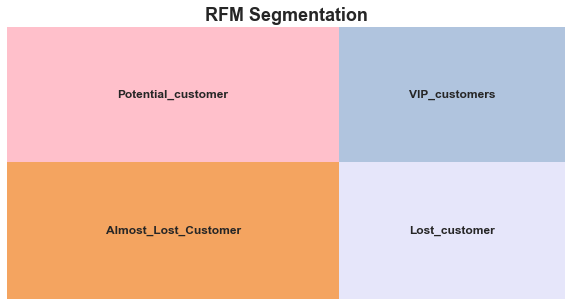

In [22]:
palette = ["#F4A460",  "#FFC0CB", "#E6E6FA", "#B0C4DE"]
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 5)
squarify.plot(sizes=rfm_nbr_seg['nmbr_seg'], 
              label= rfm_nbr_seg['segment'].unique().tolist(), alpha=1, color = palette, text_kwargs={'fontsize':12, 'weight':'bold'})
plt.title("RFM Segmentation", fontsize=18, fontweight="bold")
plt.axis('off')
plt.show()

## Segementation RFM ; approche automatique avec algorithme de clustering 

**Rappel :**

-K-Means C’est l’un des algorithmes de clustering les plus répandus. 
- Après initialiser des centroïdes en prenant des données au hasard dans le jeu de données, K-means alterne plusieurs fois ces deux étapes pour optimiser les centroïdes et leurs groupes :

        - 1.egrouper chaque objet autour du centroïde le plus proche.
        - 2.Replacer chaque centroïde selon la moyenne des descripteurs de son groupe.
- L’algorithme converge après un certain nombre d'itérations et trouve un découpage stable du jeu de données. Cependant, le nombre de Clusters est à définir par l'utilisateur.


-**Méthode de coude pour trouver nombre optimal de clusters (k)** 
- KElbowVisualizer de Yellowbrick implémente la méthode du «coude» pour sélectionner le nombre optimal de clusters en ajustant le modèle K-Means avec une plage de valeurs pour K. Si le graphique en courbes ressemble à un bras, alors le «coude» (le point d'inflexion sur la courbe) est une bonne indication du nombre de K optimal.

**Evaluation de la performance de l'algorithme Kmeans :**
- Coefficient de silhouette
-Pour vérifier si ce clustering fonctionne, on va utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.
-

In [23]:
data_model = rfm_df[['recence','frequence', 'panier_moyen']]

- Dans cette approche, on ne va pas traiter les outliers de panier_moyens.

### Data prepration 

In [24]:
# Normalization de données 
minmax = MinMaxScaler()
#sc = StandardScaler()
rfm_kmeans = pd.DataFrame(minmax.fit_transform(data_model), columns=['recence','frequence', 'panier_moyen'])
rfm_kmeans.describe()

recence     frequence  panier_moyen
count  92746.000000  92746.000000  92746.000000
mean       0.341208      0.002370      0.001782
std        0.219873      0.014887      0.005525
min        0.000000      0.000000      0.000000
25%        0.162824      0.000000      0.000490
50%        0.314121      0.000000      0.000925
75%        0.497118      0.000000      0.001703
max        1.000000      1.000000      1.000000

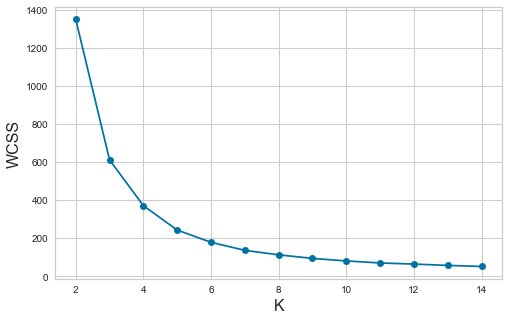

In [25]:
# Elbow méthode
k_range = range(2, 15)
kmeans_per_k = [KMeans(n_clusters=k).fit(rfm_kmeans)
                for k in k_range]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('K', fontsize=16)
plt.ylabel('WCSS', fontsize=16)
plt.show()

### Determiner le nombre optimal de K avec le librairie "YellowBrick" 

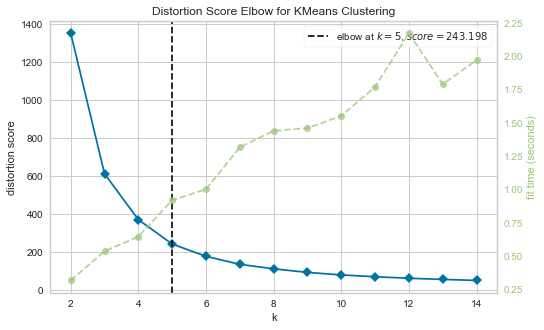

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
#Distortion score 
models = KMeans()

plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(models , metric= 'distortion' ,k=(2,15))

visualizer.fit(rfm_kmeans)        
visualizer.show()   

### Evaluer l'algorithme Kmeans

####  Coefficient de silhouette

- Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. 
- Cela permet de visualiser la densité et la séparation des clusters.

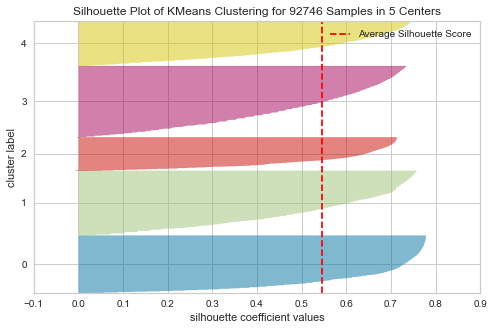

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92746 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
# Evaluer les clusters avec le coefficient de silhouette
model_best = KMeans(n_clusters = 5)

plt.figure(figsize=(8, 5))
visualizer = SilhouetteVisualizer(model_best, colors='yellowbrick')

visualizer.fit(rfm_kmeans)        
visualizer.show()       

- On constate que les clusters semblent relativement bien répartis et les séparations sont claires. 

#### Forme des clusters : distance entre les centroids

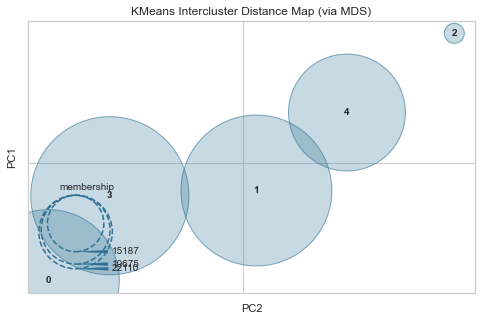

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [28]:
# Evaluer l'algorithme avec la distance entre le centroid des clusters 
plt.figure(figsize=(8, 5))
visualizer = InterclusterDistance(model_best)

visualizer.fit(rfm_kmeans)       
visualizer.show()        

- La visualisation des 'intercluster distance' montre que les clusters sont bien séparés. Le modèle de clustering semble donc performant 

- Pour trouver le meilleur K, nous allons essayer aussi d'autre métrique : 'Calinski Harabasz' qui est le rapport entre la dispersion des grappes dans et entre les groupes.

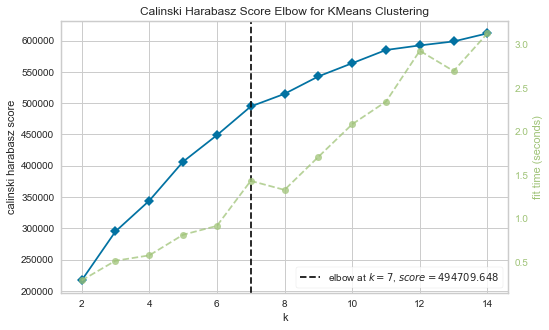

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [29]:
#calinski_harabasz sccore
models = KMeans()

plt.figure(figsize=(8, 5))
visualizer_2 = KElbowVisualizer(models , metric= 'calinski_harabasz' ,k=(2,15))

visualizer_2.fit(rfm_kmeans)        
visualizer_2.show()  

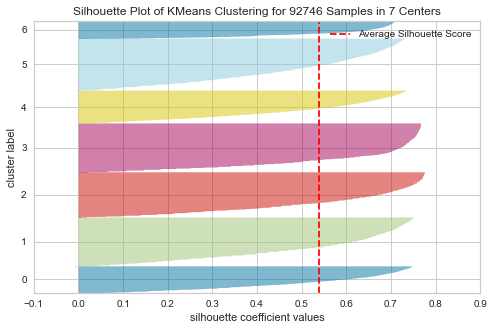

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92746 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
# Evaluer les clusters avec le coefficient de silhouette
model_best_bis = KMeans(n_clusters = 7)

plt.figure(figsize=(8, 5))
visualizer_bis = SilhouetteVisualizer(model_best_bis, colors='yellowbrick')

visualizer_bis.fit(rfm_kmeans)        
visualizer_bis.show() 

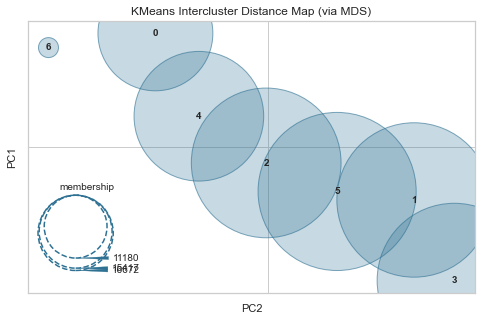

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [31]:
# Evaluer l'algorithme avec la distance entre le centroid des clusters 
plt.figure(figsize=(8, 5))
visualizer_bis2 = InterclusterDistance(model_best_bis)

visualizer_bis2.fit(rfm_kmeans)       
visualizer_bis2.show()  

- La répartition des cluster en 7 avec le métrique de "Calinski Harabasz", est plus incertain. 
- Nous allons donc conserver ce clustering en 5 groupes.

#### Stabilité à l'initialisation du K-Means


- on a initialisé l'algorithme Kmeans avec la méthode "K-Means++", ce qui réduit déjà les effets aléatoires de l'initialisation des centroïdes. 
- Nous allons à présent tester la stabilité à l'initialisation en entrainant plusieurs fois le modèle sans fixer le RandomState.

- Pour les labels initieux, nous allons conserver les clusters calculés dans le dernier modèle.
- On va ensuite les comparer avec ARI pour chacune des itérations.

In [32]:
iterations = 10
centroids = None
label_initieux  = model_best.labels_
labels_pred = []
ari= []

for i in range(iterations):
    kmeans = KMeans(
        max_iter=1,
        init=(centroids if centroids is not None else 'k-means++'),
        n_clusters = 5)
    kmeans.fit(rfm_kmeans)
    centroids = kmeans.cluster_centers_
    
    pred = kmeans.predict(rfm_kmeans)
    labels_pred.append(pred)
    ari.append(adjusted_rand_score(model_best.labels_, labels_pred[i]))

    #print(f'ARI pour itération{i} {adjusted_rand_score(model_best.labels_, labels_pred[i])}')
    #print(f'Homogeneity_score {i} {homogeneity_score(model_best.labels_, labels_pred[i])}')
   

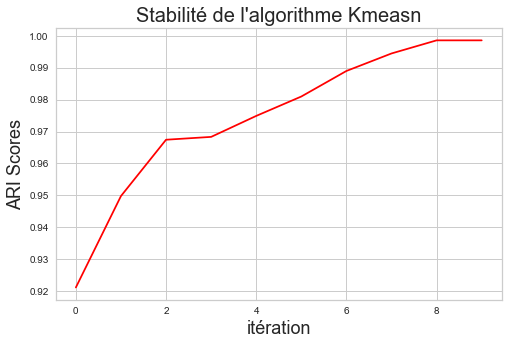

In [33]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=range(10), y=ari, color = 'red')


plt.xlabel('itération', fontsize=18)
plt.xticks(fontsize=10)

plt.ylabel('ARI Scores', fontsize=18)
plt.yticks(fontsize=10)
plt.title("Stabilité de l'algorithme Kmeasn",
          fontsize=20,
         )
plt.show()

- Les différentes itérations montrent  un score ARI proche de 1. 
- On peut donc déduire que la stabilité à l'initialisation du modèle K-Means est bonne. 

### Visualisation des clusters  

In [34]:
# Le modèle final 
model_rfm_kmeans = KMeans(n_clusters = 5).fit(rfm_kmeans)

In [35]:
# Assigner les labels au df normalizé
labels_rfm = model_rfm_kmeans.labels_

rfm_kmeans['labels'] = labels_rfm

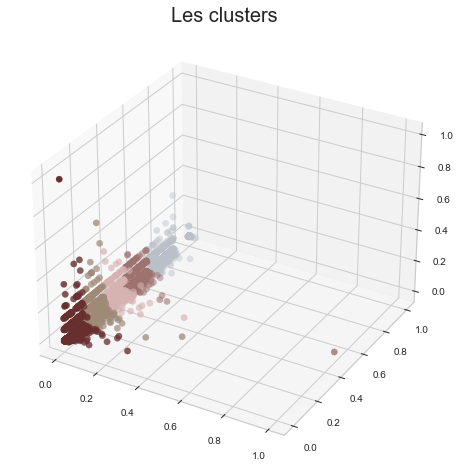

In [36]:
x =rfm_kmeans["panier_moyen"]
y =rfm_kmeans["recence"]
z =rfm_kmeans["frequence"]

#Plotting the clusters
cmap = ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78"])
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=rfm_kmeans["labels"], marker='o', cmap = cmap )
ax.set_title("Les clusters", fontsize = 20)
plt.show()

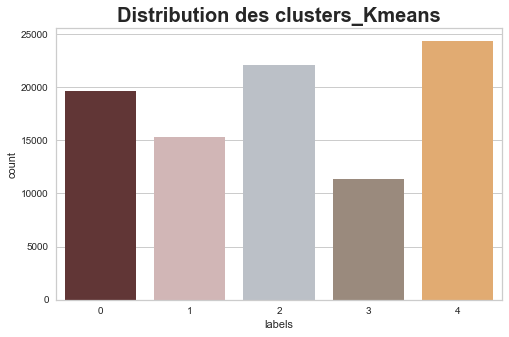

In [37]:
#Plotting countplot des clusters


plt.figure(figsize=(8, 5))
pal  = ["#682F2F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
pl = sns.countplot(x=rfm_kmeans["labels"], palette= pal)
pl.set_title("Distribution des clusters_Kmeans", fontsize = 20, weight = 'bold')
plt.show()

In [38]:
# Function pour radar chart
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
          title_font_color="blue",
        title_font_size=18)

    fig.show()

In [39]:
kmeans_clusters_means_bis = rfm_kmeans.groupby("labels").mean()



In [40]:
plot_radars(data= kmeans_clusters_means_bis, group= 'labels')

- Le radar chart montre que le clustering s'est basé principalement sur la variable récence. 

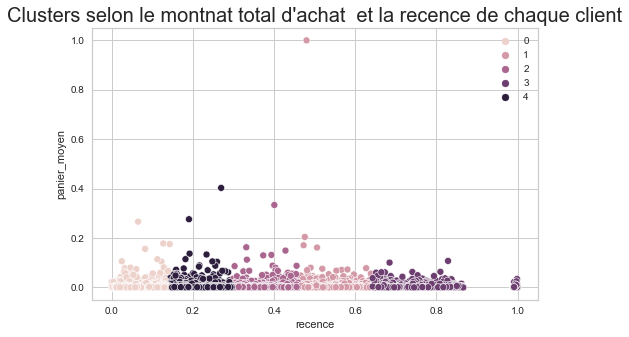

In [41]:
plt.figure(figsize = (8,5))
pl =sns.scatterplot(data = rfm_kmeans, x=rfm_kmeans["recence"], 
                    y = rfm_kmeans["panier_moyen"],
                     hue = rfm_kmeans['labels'])
pl.set_title("Clusters selon le montnat total d'achat  et la recence de chaque client", fontsize = 20)
plt.legend()
plt.show()

- On va a présent identifier les composantes métier de chaque cluster.

## Identifier les composantes métier de chaque cluster

In [42]:
# Assigner les cluster au dataframe non normalisé
data_model['kmeans_label'] = labels_rfm

In [43]:
data_model.describe()

recence     frequence   panier_moyen  kmeans_label
count  92746.000000  92746.000000   92746.000000  92746.000000
mean     237.798245      1.033177     204.376237      2.058482
std      152.591525      0.208425     603.916800      1.477127
min        1.000000      1.000000       9.590000      0.000000
25%      114.000000      1.000000      63.150000      1.000000
50%      219.000000      1.000000     110.700000      2.000000
75%      346.000000      1.000000     195.690000      4.000000
max      695.000000     15.000000  109312.640000      4.000000

In [44]:
# regroupment des clusters par valeur moyenne de R-F-M
model_rfm_means = data_model.groupby("kmeans_label").mean().round(3).reset_index()
model_rfm_means.rename(columns = {'recence' : 'recence_moy', 'frequence' :'frequence_moy',
                                  'panier_moyen':'panier_moyen_moy'})

kmeans_label  recence_moy  frequence_moy  panier_moyen_moy
0             0       48.243          1.040           205.685
1             1      379.614          1.031           208.147
2             2      261.201          1.031           200.530
3             3      511.752          1.023           200.280
4             4      152.983          1.036           206.359

###  Labelisation des clusters RFM (k_means)

- **Best Customers** : "Les clients qui ont acheté le plus récemment, et qui dépensent le plus."

- **Potential Customers** : "Les clients qui n'ont pas acheté recement mais qui dépensent beacoup. Ils sont les customers à fidéliser."                
- **Lost Customers** : "Les Clients qui n'ont pas acheté depuis un certain temps et qui n'ont pas dépensé le plus" 
- **Almost Lost Customers** : Les customers qui n'ont pas acheté depuis un certain temps mais qui ont dépensé beacoup 

- Cluster 0 : Best Custsomers
- Cluster 1 et 2 à fusionner: Almost Lost Customers
- Cluster 3 : Lost Customers  
- Cluster 4 : Potential Customers


In [45]:
rfm_kmeans.loc[rfm_kmeans.labels==2]=1
data_model['segment'] = data_model['kmeans_label'].map({
                             0 :' Best Customers ',
                             1 :'Almost Lost Customers',
                             3 :'Lost Customers',
                             4 :'Potential Customers'
                             },
                             na_action=None)

Text(0.5, 1.0, 'Nombre des clients par clusters')

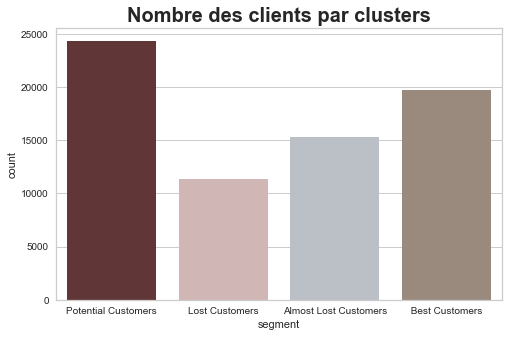

In [46]:
plt.figure(figsize=(8,5))
pl=sns.countplot(data_model['segment'], palette= pal)
pl.set_title("Nombre des clients par clusters", fontsize = 20, weight = 'bold')

In [47]:
rfm_kmeans['Segment_lable'] = data_model['segment']
rfm_kmeans

recence  frequence  panier_moyen  labels          Segment_lable
0      0.159942        0.0      0.001210       4    Potential Customers
1      0.164265        0.0      0.000161       4    Potential Customers
2      0.772334        0.0      0.000701       3         Lost Customers
3      0.461095        0.0      0.000311       1  Almost Lost Customers
4      1.000000        1.0      1.000000       1                    NaN
...         ...        ...           ...     ...                    ...
92741  0.642651        0.0      0.037741       3         Lost Customers
92742  1.000000        1.0      1.000000       1                    NaN
92743  0.817003        0.0      0.000941       3         Lost Customers
92744  0.170029        0.0      0.001135       4    Potential Customers
92745  0.695965        0.0      0.000567       3         Lost Customers

[92746 rows x 5 columns]

In [48]:
rfm_agg = pd.DataFrame(rfm_kmeans.groupby('Segment_lable').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'panier_moyen': ['mean', 'count']
})).reset_index()
rfm_agg

Segment_lable   recence frequence panier_moyen       
                              mean      mean         mean  count
0        Best Customers   0.068073  0.002824     0.001794  19675
1  Almost Lost Customers  0.545553  0.002242     0.001817  15263
2         Lost Customers  0.735954  0.001654     0.001745  11359
3    Potential Customers  0.218996  0.002556     0.001800  24339

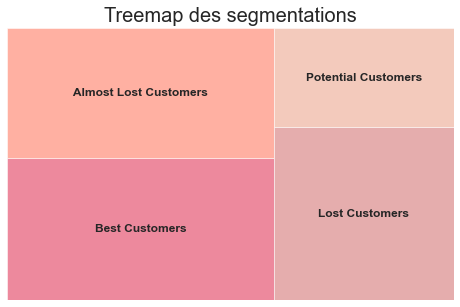

In [78]:
df_seg = pd.DataFrame(data_model['segment'].value_counts())

size = df_seg['segment'].unique().tolist()
label= df_seg.index
plt.figure(figsize = (8,5))
colors =['#DC143C','#FF6347','#CD5C5C','#E9967A']
squarify.plot(sizes = size, label=label, color = colors,  
              alpha=0.5, text_kwargs={'fontsize':12, 'weight':'bold'})

plt.axis('off')
plt.title('Treemap des segmentations', fontsize = 20)
plt.show()

# Clustering sur l'ensemble des varaibles

In [49]:
# Sélectionner les varaibles perinenets pour clustering7

all_data_model = rfm_df[[               
'customer_unique_id',
 'Note_Moy_Com',
 'delivery_days',
 'payment_installments',
 'recence',
 'frequence',
 'panier_moyen'
]]

#### Data prepration

In [50]:
data_to_scale = all_data_model.drop(['customer_unique_id'], axis=1)
data_scaled = pd.DataFrame(minmax.fit_transform(data_to_scale), columns=data_to_scale.columns)

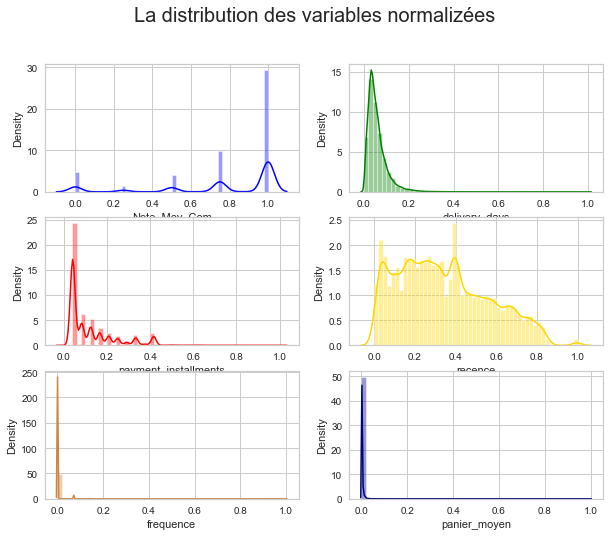

In [51]:
# Plot la distribution des variables après recentrage
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
sns.set(font_scale = 0.9)
fig.suptitle("La distribution des variables normalizées", fontsize = 20)

plot1 = sns.distplot(data_scaled['Note_Moy_Com'], color="blue", ax=axes[0,0], kde=True)
plot2 = sns.distplot(data_scaled['delivery_days'], color="green", ax=axes[0,1], kde=True)
plot3 = sns.distplot(data_scaled['payment_installments'], color="red",ax=axes[1,0], kde=True)
plot4 = sns.distplot(data_scaled['recence'], color="gold",ax=axes[1,1], kde=True)
plot5 = sns.distplot(data_scaled['frequence'], color="peru",ax=axes[2,0], kde=True)
plot6 = sns.distplot(data_scaled['panier_moyen'], color="navy",ax=axes[2,1], kde=True)


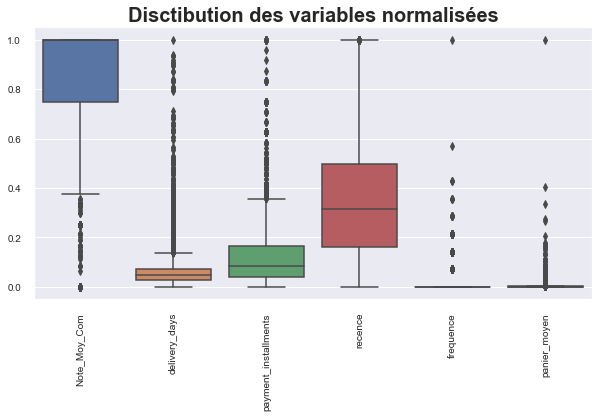

In [52]:
plt.figure(figsize = (10,5))
sns.boxplot(data =data_scaled) 
plt.title('Disctibution des variables normalisées', fontsize = 20 , weight='bold')
plt.xticks(rotation=90, fontsize = 10)
plt.show()

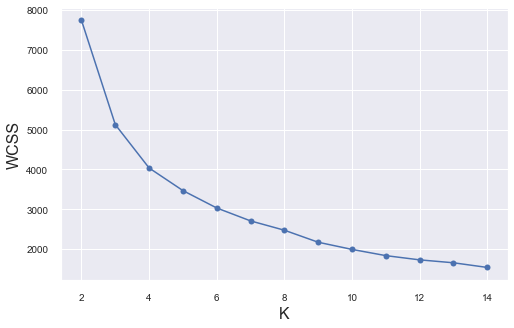

In [53]:
# Méthode Elbow
k_range = range(2, 15)
kmeans_per_k = [KMeans(n_clusters=k, random_state= 42).fit(data_scaled)
                for k in k_range]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('K', fontsize=16)
plt.ylabel('WCSS', fontsize=16)
plt.show()

### Determiner le nbmre optimal de K avec le librairie "YellowBrick" 

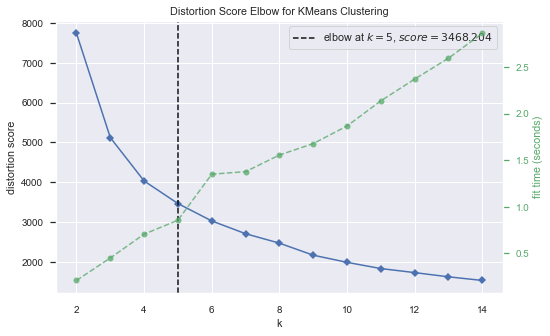

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
plt.figure(figsize=(8, 5))
model_d = KMeans()
visualizer_d = KElbowVisualizer(model_d , metric= 'distortion' ,k=(2,15))

visualizer_d.fit(data_scaled)        
visualizer_d.show()

### Evaluer l'algorithme Kmeans

####  Coefficient de silhouette

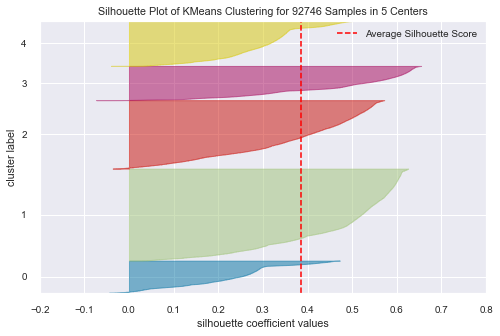

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92746 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [55]:
plt.figure(figsize=(8, 5))

model_best_d = KMeans(n_clusters = 5)
visualizer_d = SilhouetteVisualizer(model_best_d, colors='yellowbrick')

visualizer_d.fit(data_scaled)     
visualizer_d.show()

- On constate que les clusters semblent relativement bien répartis et les séparations sont claires, avec cependant quelques erreurs sur des clusters.

#### Forme des clusters : distance entre les centroids

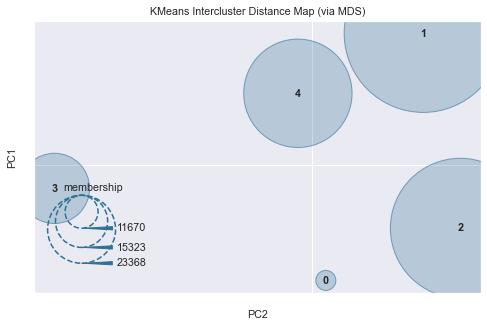

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [56]:
plt.figure(figsize=(8, 5))
visualizer_center_d = InterclusterDistance(model_best_d, legend= 'False')

visualizer_center_d.fit(data_scaled)        
visualizer_center_d.show() 

- La visualisation des 'intercluster distance' pour l'ensemble des variables montre que les clusters sont bien séparés. Le modèle de clustering semble donc performant

#### Stabilité à l'initialisation du K-Means

In [57]:
iterations_all = 20
centroids_all = None
label_initieux_all= model_best_d.labels_
labels_pred_all = []
ari_all = []

for i in range(iterations_all):
    kmeans_all = KMeans(
        max_iter=1,
        init=(centroids_all if centroids_all is not None else 'k-means++'),
        n_clusters = 5)
    kmeans_all.fit(data_scaled)
    centroids_all = kmeans_all.cluster_centers_
    
    pred_all = kmeans_all.predict(data_scaled)
    labels_pred_all.append(pred_all)
    ari_all.append(adjusted_rand_score(model_best_d.labels_, labels_pred_all[i]))

    print(f'ARI pour itération{i} {adjusted_rand_score(model_best_d.labels_, labels_pred_all[i])}')
    #print(f'Homogeneity_score {i} {homogeneity_score(model_best.labels_, labels_pred[i])}')
    

ARI pour itération0 0.8899590719465134
ARI pour itération1 0.9570330650674231
ARI pour itération2 0.9821479853546621
ARI pour itération3 0.9926638975724082
ARI pour itération4 0.9960957746652196
ARI pour itération5 0.9960957746652196
ARI pour itération6 0.9960957746652196
ARI pour itération7 0.9960957746652196
ARI pour itération8 0.9960957746652196
ARI pour itération9 0.9960957746652196
ARI pour itération10 0.9960957746652196
ARI pour itération11 0.9960957746652196
ARI pour itération12 0.9960957746652196
ARI pour itération13 0.9960957746652196
ARI pour itération14 0.9960957746652196
ARI pour itération15 0.9960957746652196
ARI pour itération16 0.9960957746652196
ARI pour itération17 0.9960957746652196
ARI pour itération18 0.9960957746652196
ARI pour itération19 0.9960957746652196


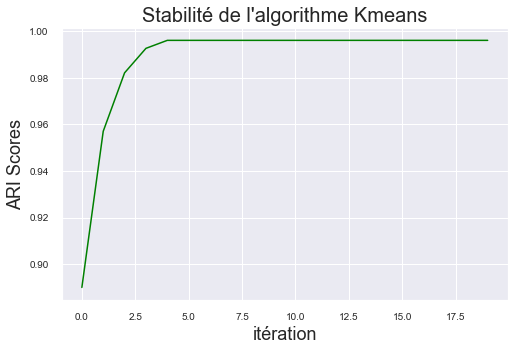

In [58]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=range(20), y=ari_all, color = 'green')


plt.xlabel('itération', fontsize=18)
plt.xticks(fontsize=10)

plt.ylabel('ARI Scores', fontsize=18)
plt.yticks(fontsize=10)
plt.title("Stabilité de l'algorithme Kmeans",
          fontsize=20,
         )
plt.show()

- Les différentes itérations montrent un score ARI proche de 1. 
- On peut donc déduire que la stabilité à l'initialisation du modèle K-Means est bonne. 

In [59]:
model_all_final = KMeans(n_clusters = 5).fit(data_scaled)

In [60]:
labels_d = model_all_final.labels_

data_scaled['labels'] = labels_d
all_data_model['labels'] = labels_d

### Visualisation des clusters  

In [61]:
data_scaled['labels'] = labels_d
kmeans_clusters_means_d_bis = data_scaled.groupby("labels").mean()

In [62]:
plot_radars(data=kmeans_clusters_means_d_bis,
            group="labels")

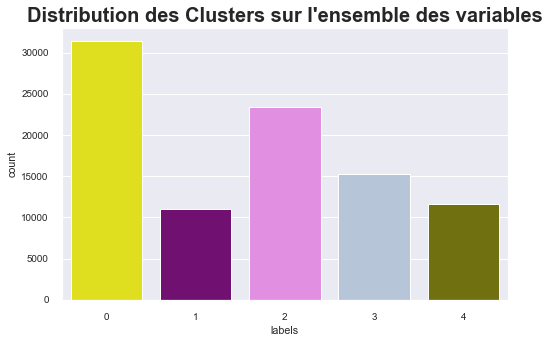

In [63]:
#Plotting countplot of clusters
plt.figure(figsize=(8, 5))
pal2  = ["#FFFF00",  "#800080", "#EE82EE", "#B0C4DE", "#808000"]
sns.countplot(x= all_data_model["labels"], palette= pal2)
plt.title("Distribution des Clusters sur l'ensemble des variables", fontsize = 20, weight = 'bold')
plt.show()

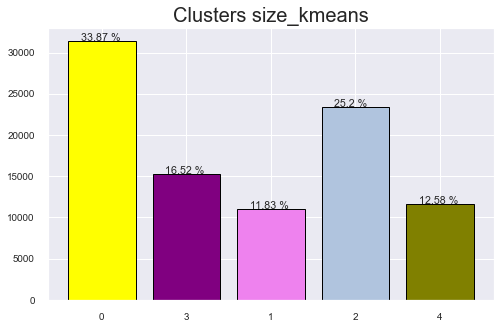

In [64]:
cluster_size={}
for i in labels_d:
    if i not in cluster_size:
        cluster_size[i]=1
    else:
        cluster_size[i]+=1

fig=plt.figure(figsize=[8,5])
#fig.patch.set_facecolor('#DC143C')
fig.patch.set_alpha(0.7)
plt.title("Clusters size_kmeans", fontsize = 20) 
plt.bar(range(0,len(cluster_size)),cluster_size.values(),color= pal2, edgecolor='black')
for i,num in enumerate(cluster_size.keys()):
    height=cluster_size[num]+20
    x=i-0.25
    pourcent=cluster_size[num]/labels_d.shape[0]*100
    plt.text(x,height,"{} % ".format(round(pourcent,2)))
plt.xticks(range(0,len(cluster_size)),cluster_size.keys())
plt.show()

In [65]:
all_data_model.describe()


Note_Moy_Com  delivery_days  payment_installments       recence  \
count  92746.000000   92746.000000          92746.000000  92746.000000   
mean       4.153367      12.060600              2.898307    237.798245   
std        1.280530       9.466231              2.675020    152.591525   
min        1.000000       0.000000              0.000000      1.000000   
25%        4.000000       6.000000              1.000000    114.000000   
50%        5.000000      10.000000              2.000000    219.000000   
75%        5.000000      15.000000              4.000000    346.000000   
max        5.000000     208.000000             24.000000    695.000000   

          frequence   panier_moyen        labels  
count  92746.000000   92746.000000  92746.000000  
mean       1.033177     204.376237      1.621213  
std        0.208425     603.916800      1.413519  
min        1.000000       9.590000      0.000000  
25%        1.000000      63.150000      0.000000  
50%        1.000000     110.700000      2.000000  
75%        1.000000     195.690000      3.000000  
max       15.000000  109312.640000      4.000000

In [67]:
all_data_kmeans_mean = all_data_model.groupby('labels').mean().round(3)
all_data_kmeans_mean = all_data_kmeans_mean.rename(columns = {
                                            'Note_Moy_Com' : "score_mean",
                                           'delivery_days': "deliveray_days_mean",
                                           'payment_installments' : 'payment_installments_mean',
                                           'recence' : 'recence_mean',
                                           'frequence': 'frequence_mean',
                                           'panier_moyen': 'panier_moyen_mean'})

all_data_kmeans_mean

score_mean  deliveray_days_mean  payment_installments_mean  \
labels                                                               
0            4.997                9.720                      2.719   
1            3.670               12.732                      3.062   
2            4.998               10.876                      3.076   
3            3.705               12.241                      2.684   
4            1.236               19.863                      3.152   

        recence_mean  frequence_mean  panier_moyen_mean  
labels                                                   
0            122.272           1.038            183.429  
1            396.372           1.029            196.532  
2            387.718           1.030            189.786  
3            136.150           1.040            194.422  
4            232.853           1.022            310.417

## Labelisation des clusters avec la connaissances spécifiques au domaine


- **Cluster 0  : Best Satisfied Customers** : Les clients les plus satisfaits avec une fréquence d'achat au dessus de moyenne.Ces clients sont satisfaits et le délais de livraison est en desous de moyen.


- **Clusters 2 :  Lost Customers but Satisfied ** : Ces client n'ont pas réalisé plusieurs commandes. Leurs derniers commande date de plus d'un ans. Cependant ils ont dépensé audessus de moyenne. Cependant ils ont satisfaits 

- **Cluster 1 et  3: Potential Customrs** : Les clients qui ont fait des achat récement. Ils sont moyennement satisfait. Ils peuvent etre donc incité par un campagne de markieting. 

- **Clsuter 4- Lost Customers_Unsatisfied** :Ce sont des clients mécontants (les avis sont mauvais).Leur insatisfaction peuvnet etre à cause de délais de livraison. Ces client ont été livré avec un délais livraison au dessus de moyenne. Ce sont cependant les clients qui ont le plus dépensé ,et avec un nombre elevé d'échéances. 





In [68]:
all_data_model.loc[all_data_model.labels==3]=1
all_data_model['segment'] = all_data_model['labels'].map({
                             0 :'Best Customers_Satisfied',
                             1 :'Potential Customers',    
                             2 :'Lost Customers_Satisfied',
                             4 :'Lost Customers_Unsatisfied'
                             },
                             na_action=None)

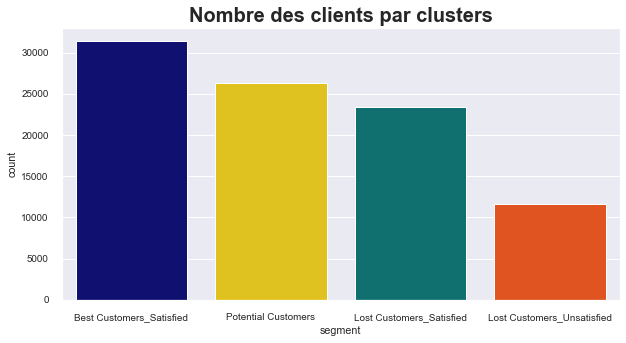

In [69]:
#Plotting countplot of clusters
plt.figure(figsize=(10, 5))
colors_bis =['#000080','#FFD700','#008080','#FF4500']
sns.countplot(x= all_data_model["segment"], palette= colors_bis, )
plt.title("Nombre des clients par clusters", fontsize = 20, weight = 'bold')
plt.show()

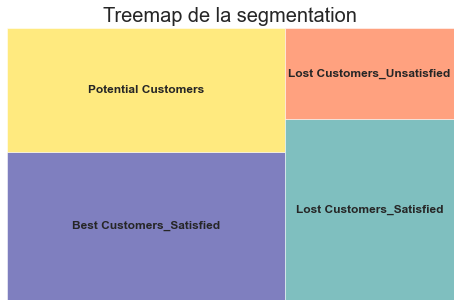

In [71]:
df_seg_bis = pd.DataFrame(all_data_model['segment'].value_counts())

size_bis = df_seg_bis['segment'].unique().tolist()
label_bis = df_seg_bis.index
plt.figure(figsize = (8,5))
colors_bis =['#000080','#FFD700','#008080','#FF4500']
squarify.plot(sizes = size_bis, label=label_bis, color = colors_bis,  
              alpha=0.5, text_kwargs={'fontsize':12, 'weight':'bold'})

plt.axis('off')
plt.title('Treemap de la segmentation', fontsize = 20)
plt.show()

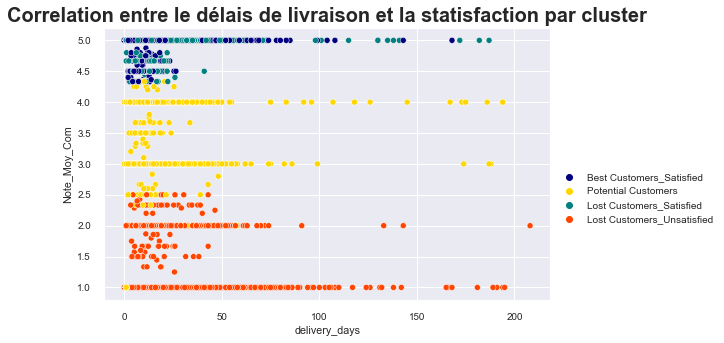

In [72]:
palette2 = ['#DC143C', '#006400', '#8B008B', '#FFD700']

plt.figure(figsize=(8,5))
sns.scatterplot(data= all_data_model, x = 'delivery_days', y = 'Note_Moy_Com' , hue = 'segment', palette = colors_bis)
plt.title('Correlation entre le délais de livraison et la statisfaction par cluster', fontsize = 20, weight = 'bold')
plt.legend(bbox_to_anchor=(1,0.5), loc="best", fontsize= 10)
plt.show()

## Conclusion 
- On a partitionné les cleints avec deux approches : approche analytique de segementation RFM, basée sur R, F et M , et une approche automatique en utilisant un algorithmes d'apprenstissage non_supervisée: K-Means. 
- Pour la segmentation avec algorithme KMeans, on a choisi les variables telle que la récence, la fréquence, le panier moyen, nombre de paiment paiement échelonné, le délais de livraison et l'avis de chaque client. 
- Le résultat de la segmenataion avec l'algorithme non-suppervisé de Kmeans est de 5 clusters. 
- Vu l'objectif de l'entreprise et la startégie de marketing, on pourrait fusionner les clusters déjà crées. 
